# Stroke Prediction

## 1. Importing the necessary libraries and loading the dataset

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from collections import Counter 
from scipy.stats import loguniform, uniform
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import warnings
from sklearn.metrics import classification_report, confusion_matrix
warnings.filterwarnings("ignore")

In [143]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [144]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## 2. Fast Glancing at Data

| Attribute          | Description                                                             | Values / Type                                                                 |
|--------------------|-------------------------------------------------------------------------|-------------------------------------------------------------------------------|
| `id`               | unique identifier                                                       | Unique Identifier                                                             |
| `gender`           | Gender of the patient                                                   | `"Male"`, `"Female"`, `"Other"`                                               |
| `age`              | age of the patient                                                      | Numerical                                                                     |
| `hypertension`     | 0 if the patient doesn't have hypertension, 1 if the patient has        | `0`, `1` (Binary)                                                             |
| `heart_disease`    | 0 if the patient doesn't have any heart diseases, 1 if the patient has  | `0`, `1` (Binary)                                                             |
| `ever_married`     | Whether the patient has ever been married                             | `"No"`, `"Yes"`                                                               |
| `work_type`        | Type of employment                                                      | `"children"`, `"Govt_job"`, `"Never_worked"`, `"Private"`, `"Self-employed"`  |
| `Residence_type`   | Type of residence area                                                  | `"Rural"`, `"Urban"`                                                          |
| `avg_glucose_level`| average glucose level in blood                                          | Numerical                                                                     |
| `bmi`              | body mass index                                                         | Numerical                                                                     |
| `smoking_status`   | Patient's smoking status                                                | `"formerly smoked"`, `"never smoked"`, `"smokes"`, `"Unknown"`*                |
| `stroke`           | 1 if the patient had a stroke or 0 if not (Target Variable)             | `0`, `1` (Binary)                                                             |

*Note: The "Unknown" category in `smoking_status` might represent missing or unrecorded information.*

In [145]:
# Shape of the data
print("Shape:", df.shape)

Shape: (5110, 12)


In [146]:
# Data types and non-null info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [147]:
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [148]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [149]:
# Drop column id
df = df.drop(columns=['id'])

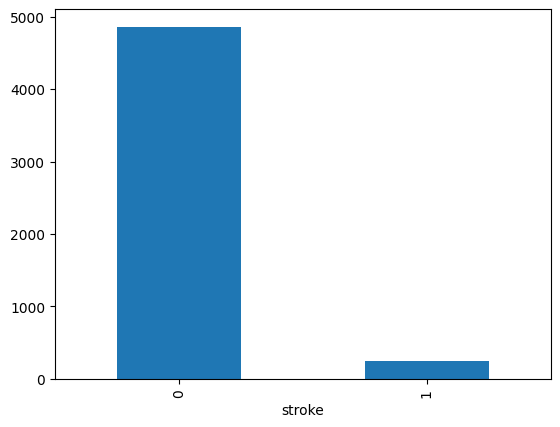

In [150]:
# Check the balance of the target variable
df['stroke'].value_counts()

# plot the balance of the target variable
df['stroke'].value_counts().plot(kind='bar')    
plt.show()

Nhận xét: Dữ liệu mất cân bằng

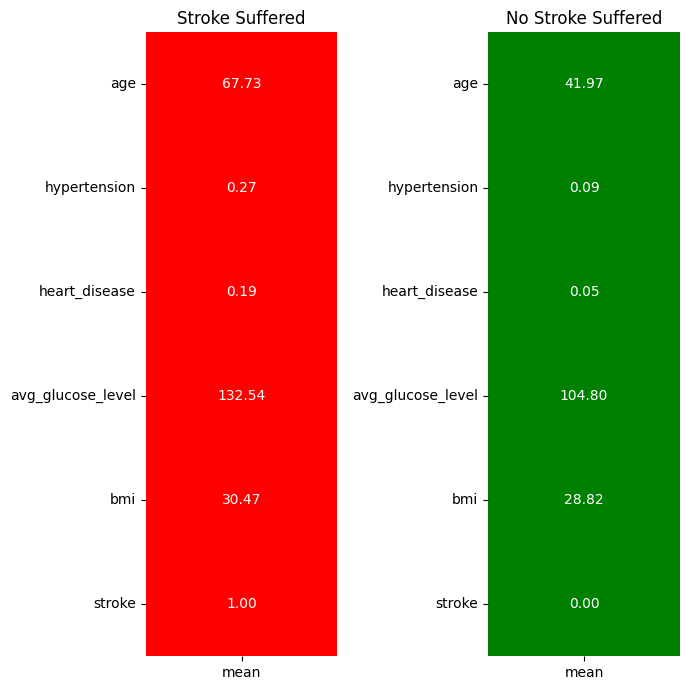

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


stroke = df[df['stroke'] == 1].describe().T
no_stroke = df[df['stroke'] == 0].describe().T

stroke_means = stroke['mean']
no_stroke_means = no_stroke['mean']

# Create a DataFrame for comparison
comparison = pd.DataFrame({
    'Stroke Suffered': stroke_means,
    'No Stroke Suffered': no_stroke_means
})

# Prepare color lists
colors_stroke = []
colors_no_stroke = []
for idx in comparison.index:
    if comparison.loc[idx, 'Stroke Suffered'] > comparison.loc[idx, 'No Stroke Suffered']:
        colors_stroke.append('red')
        colors_no_stroke.append('green')
    else:
        colors_stroke.append('green')
        colors_no_stroke.append('red')

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(7, 7))

# Stroke Suffered column
sns.heatmap(
    stroke[['mean']], 
    annot=True, 
    fmt=".2f", 
    cmap=sns.color_palette(colors_stroke),  # Custom color palette
    cbar=False, 
    ax=axes[0]
)
axes[0].set_title('Stroke Suffered')

# No Stroke Suffered column (use a neutral color)
sns.heatmap(
    no_stroke[['mean']], 
    annot=True, 
    fmt=".2f", 
    cmap=colors_no_stroke, 
    cbar=False, 
    ax=axes[1]
)
axes[1].set_title('No Stroke Suffered')

plt.tight_layout()
plt.show()

Mọi chỉ số đều lớn hơn so với người không mắc bệnh

## EDA

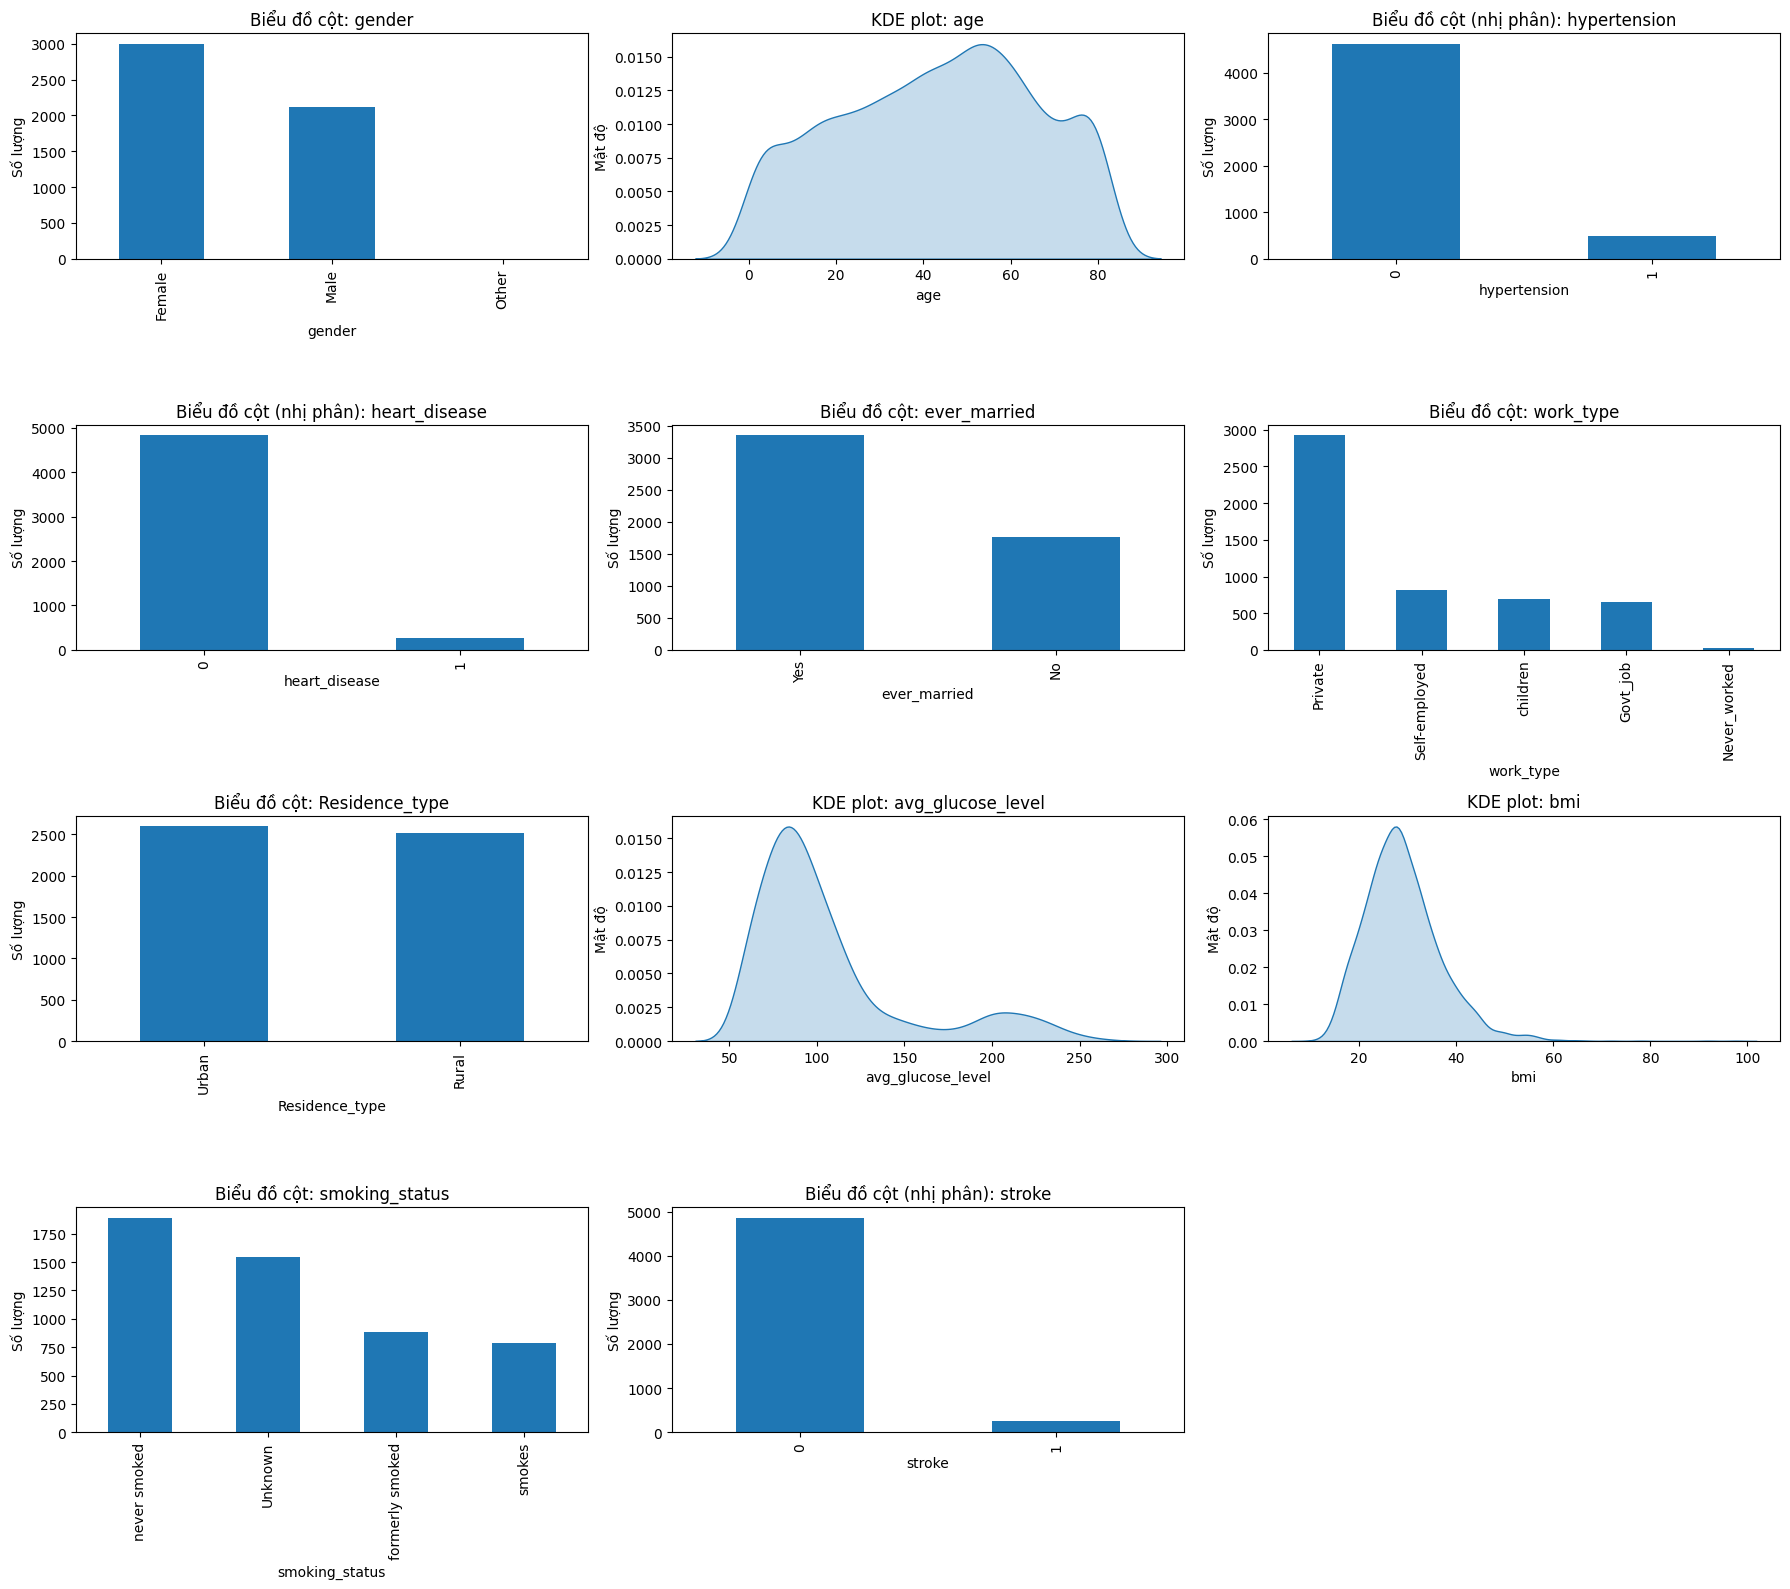

In [152]:
cols = df.columns.tolist()
n_cols = 3
n_rows = int(np.ceil(len(cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4))
axes = axes.flatten()

for idx, col in enumerate(cols):
    ax = axes[idx]
    col_data = df[col]
    unique_values = col_data.dropna().unique()
    # Nếu là dạng chữ hoặc category
    if col_data.dtype == 'object' or col_data.dtype.name == 'category':
        col_data.value_counts().plot(kind='bar', ax=ax)
        ax.set_title(f'Biểu đồ cột: {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Số lượng')
    # Nếu là số và chỉ có 2 giá trị 0/1
    elif pd.api.types.is_numeric_dtype(col_data) and set(unique_values).issubset({0, 1}):
        col_data.value_counts().sort_index().plot(kind='bar', ax=ax)
        ax.set_title(f'Biểu đồ cột (nhị phân): {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Số lượng')
        ax.set_xticks([0, 1])
    # Nếu là số thực sự
    elif pd.api.types.is_numeric_dtype(col_data):
        sns.kdeplot(col_data.dropna(), ax=ax, fill=True)
        ax.set_title(f'KDE plot: {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Mật độ')
    else:
        ax.axis('off')
        ax.set_title(f'Không xác định kiểu dữ liệu: {col}')

# Ẩn các subplot thừa nếu có
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

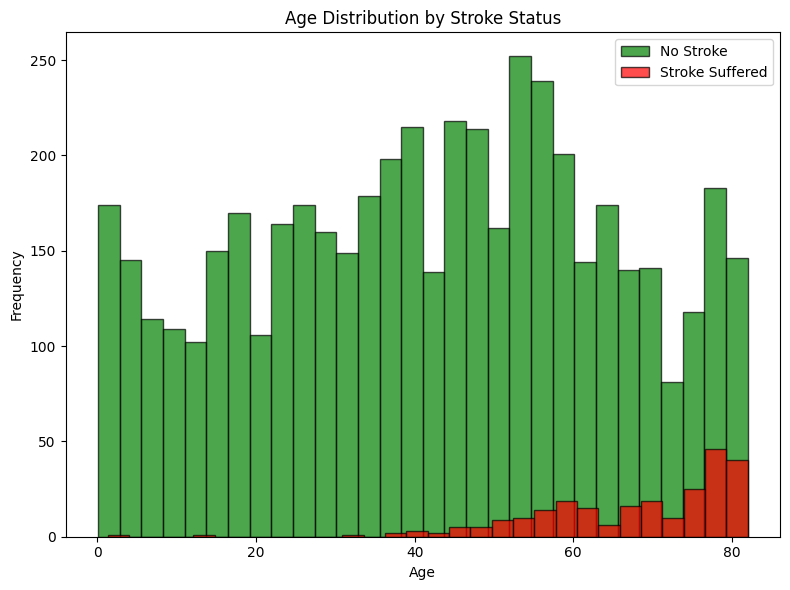

In [153]:
plt.figure(figsize=(8, 6))
# Histogram for stroke == 0
plt.hist(df[df['stroke'] == 0]['age'], bins=30, alpha=0.7, label='No Stroke', color='green', edgecolor='black')
# Histogram for stroke == 1
plt.hist(df[df['stroke'] == 1]['age'], bins=30, alpha=0.7, label='Stroke Suffered', color='red', edgecolor='black')
plt.title('Age Distribution by Stroke Status')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

Nhận xét: người mắc bệnh đột quỵ đa số nằm ở độ tuổi từ 45 trở lên, có thể do từ độ tuổi này thì hệ thống miễn dịch và khả năng chịu đựng suy giảm, đồng thời mạch máu không còn đàn hồi, trở nên cứng hơn và độ cô đặc của máu cũng tăng. Điều này khiến máu dễ bị đông và lưu lượng máu đến não giảm, dẫn đến đột quỵ
+ Có insight ở đây: tuổi càng cao thì càng dễ đột quỵ

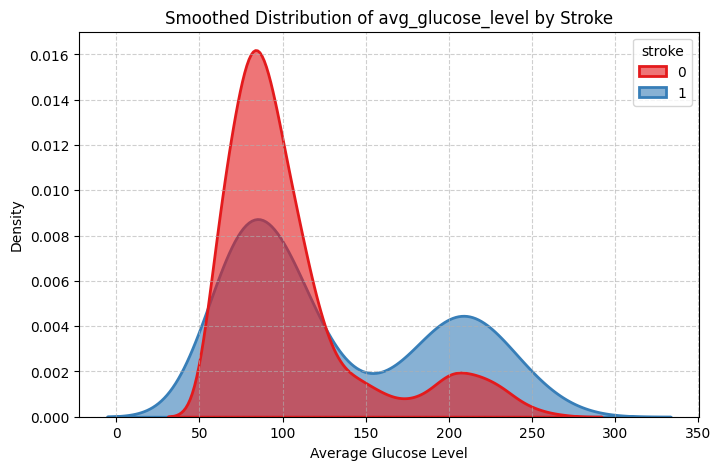

In [154]:
plt.figure(figsize=(8, 5))
ax = sns.kdeplot(
    data=df,
    x='avg_glucose_level',
    hue='stroke',
    fill=True,
    common_norm=False,
    palette='Set1',
    alpha=0.6,
    linewidth=2
)
ax.set_xlabel('Average Glucose Level')
ax.set_ylabel('Density')
ax.set_title('Smoothed Distribution of avg_glucose_level by Stroke')
ax.grid(True, linestyle='--', alpha=0.6)
plt.show()

--> Ở đây không rõ ràng rằng liệu average_glucose_level có ảnh hưởng đến stroke hay không vì các đỉnh của hai histogram khá căn đều nhau, có khả năng là người khảo sát trùng hợp lấy thông tin của nhiều người có giá trị glucose_level ở các đỉnh đó (do cả stroke = 0 và stroke = 1 có đỉnh đều ở đó)

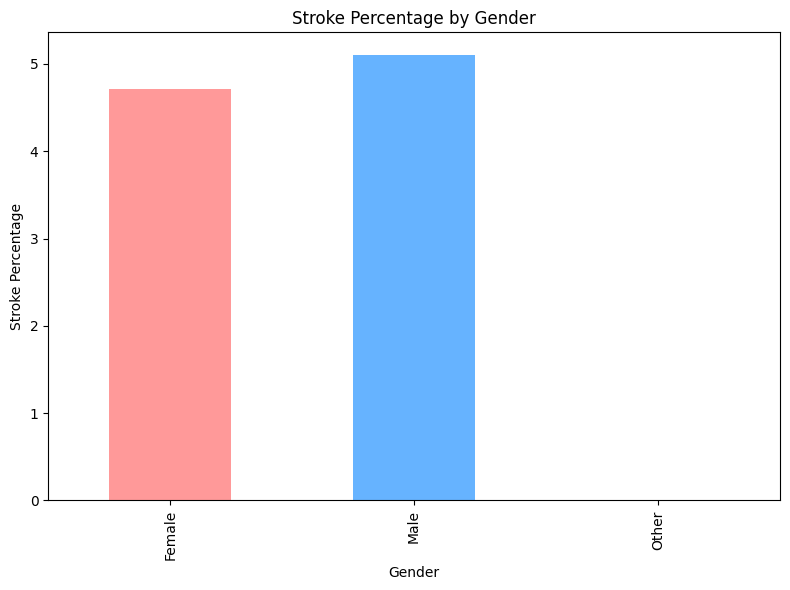

In [155]:
# Calculate the percentage of stroke for each gender
stroke_percentage = df.groupby('gender')['stroke'].mean() * 100
stroke_percentage.plot(kind='bar', figsize=(8, 6), color=['#ff9999','#66b3ff'])
plt.title('Stroke Percentage by Gender')
plt.xlabel('Gender')
plt.ylabel('Stroke Percentage')
plt.tight_layout()
plt.show()

--> Nhận thấy tỷ lệ mắc bệnh của nam giới và nữ giới không có sự chênh lệch đáng kể, chứng tỏ là giới tính không ảnh hưởng đến bệnh stroke

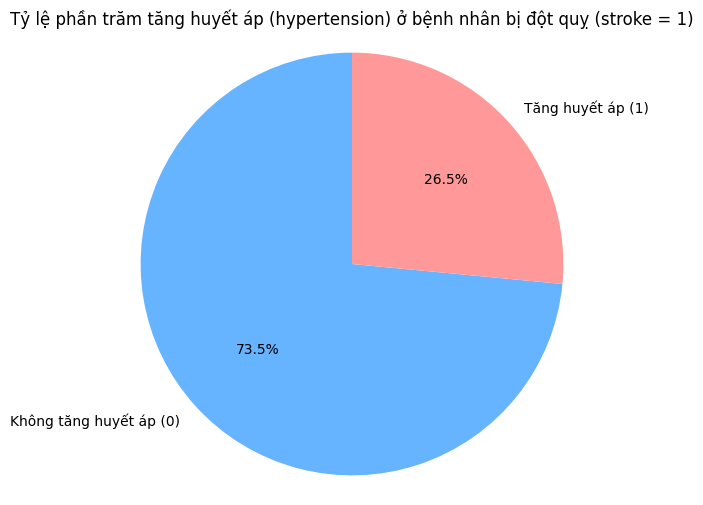

In [156]:
# Lọc các dòng có stroke = 1
stroke_1 = df[df['stroke'] == 1]

# Đếm số lượng từng giá trị của hypertension trong nhóm này
hypertension_counts = stroke_1['hypertension'].value_counts(normalize=True) * 100

# Tạo nhãn cho biểu đồ
labels = ['Không tăng huyết áp (0)', 'Tăng huyết áp (1)']

# Đảm bảo đúng thứ tự nhãn theo index (0, 1)
sizes = [hypertension_counts.get(0, 0), hypertension_counts.get(1, 0)]

# Vẽ biểu đồ tròn
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
plt.title('Tỷ lệ phần trăm tăng huyết áp (hypertension) ở bệnh nhân bị đột quỵ (stroke = 1)')
plt.axis('equal')
plt.show()

--> Ta thấy được rằng trong các bệnh nhân bị stroke thì số bệnh nhân không tăng huyết áp chiếm tỷ lệ cao hơn số bệnh nhân tăng huyết áp. Tuy nhiên điều này make-no-sense vì có thể do số lượng mẫu không tăng huyết áp ta lấy cao hơn nên mới có tỷ lệ vậy. Thế nên ta tiếp tục vẽ thêm biểu đồ nữa để xem xét

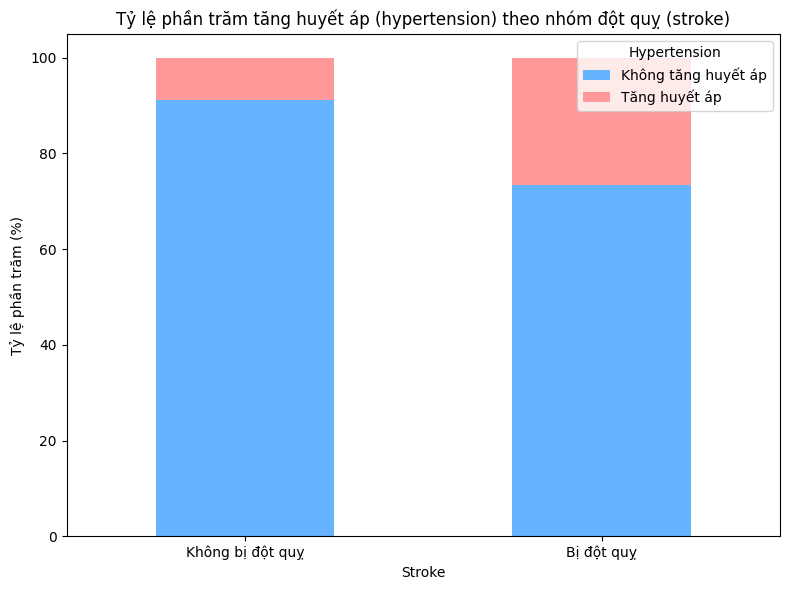

In [157]:
# Tính tỷ lệ phần trăm của hypertension cho từng nhóm stroke
hypertension_percent = (
    df.groupby(['stroke', 'hypertension']).size()
    .groupby(level=0).apply(lambda x: 100 * x / x.sum())
    .unstack(fill_value=0)
)

# Vẽ biểu đồ cột chồng
ax = hypertension_percent.plot(
    kind='bar',
    stacked=True,
    figsize=(8, 6),
    color=['#66b3ff', '#ff9999']
)

# Đặt tiêu đề và nhãn
plt.title('Tỷ lệ phần trăm tăng huyết áp (hypertension) theo nhóm đột quỵ (stroke)')
plt.xlabel('Stroke')
plt.ylabel('Tỷ lệ phần trăm (%)')
plt.legend(['Không tăng huyết áp', 'Tăng huyết áp'], title='Hypertension')

# Thay đổi giá trị trục x
ax.set_xticks([0, 1])  # Vị trí các điểm trên trục x (0 và 1)
ax.set_xticklabels(['Không bị đột quỵ', 'Bị đột quỵ'], rotation=0)  # Nhãn mới cho trục x

plt.tight_layout()

plt.show()

--> Có vẻ ta thấy rằng khi ở cột không bị đột quỵ, tỷ lệ người tăng huyết áp có vẻ ít hơn. Tuy nhiên khi chuyển sang qua cột bị đột quỵ, tỷ lệ người tăng huyết áp có vẻ cao hơn đáng kể. Chứng tỏ huyết áp cao có ảnh hưởng đến bệnh đột quỵ.  
Theo cổng thông tin điện tử tỉnh Tiền Giang thì: Tăng huyết áp là nguy cơ hàng đầu gây đột quỵ. Tai biến này thường để lại di chứng hết sức nặng nề như liệt nửa người, nói ngọng, bại não, hôn mê, sống đời sống thực vật, thậm chí tử vong…


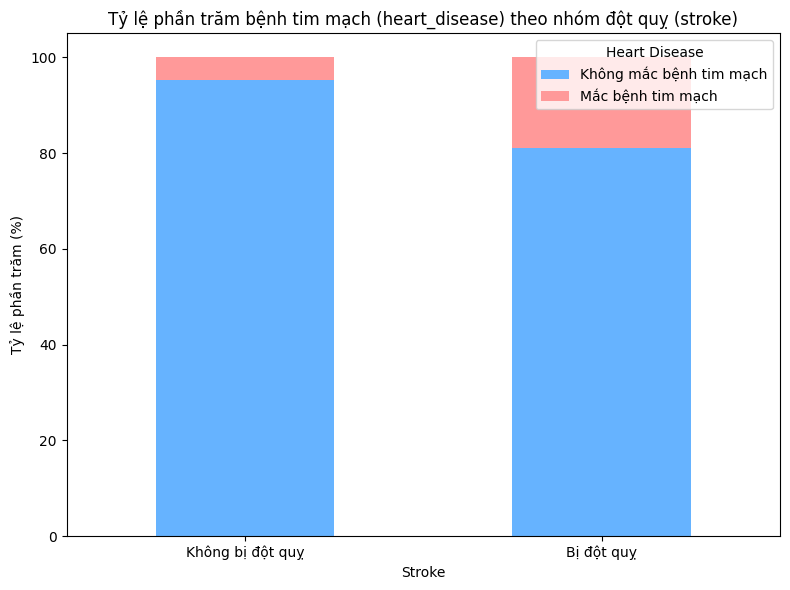

In [158]:
# Tính tỷ lệ phần trăm của heart_disease cho từng nhóm stroke
heart_disease_percent = (
    df.groupby(['stroke', 'heart_disease']).size()
    .groupby(level=0).apply(lambda x: 100 * x / x.sum())
    .unstack(fill_value=0)
)

# Vẽ biểu đồ cột chồng
ax = heart_disease_percent.plot(
    kind='bar',
    stacked=True,
    figsize=(8, 6),
    color=['#66b3ff', '#ff9999']
)

# Đặt tiêu đề và nhãn
plt.title('Tỷ lệ phần trăm bệnh tim mạch (heart_disease) theo nhóm đột quỵ (stroke)')
plt.xlabel('Stroke')
plt.ylabel('Tỷ lệ phần trăm (%)')
plt.legend(['Không mắc bệnh tim mạch', 'Mắc bệnh tim mạch'], title='Heart Disease')

# Thay đổi giá trị trục x
ax.set_xticks([0, 1])  # Vị trí các điểm trên trục x (0 và 1)
ax.set_xticklabels(['Không bị đột quỵ', 'Bị đột quỵ'], rotation=0)  # Nhãn mới cho trục x

plt.tight_layout()
plt.show()


Một cách tương tự ta thấy rằng bệnh tim mạch có vẻ cũng là nguyên nhân gây nên đột quỵ.   
Tuy nhiên ta sẽ kiểm tra xem liệu cột này với cột heart_disease có liên quan với nhau không chủ yếu để tìm ra 1 insight nào đó


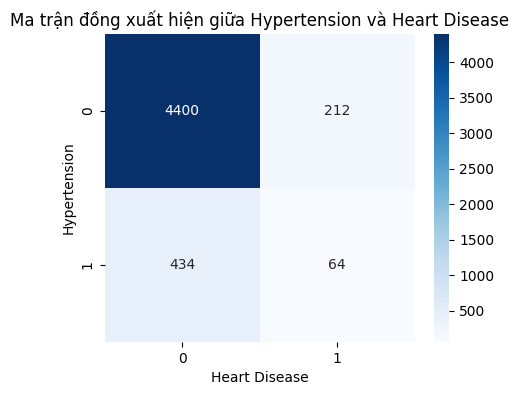

In [159]:
# Tạo bảng chéo (contingency table)
contingency = pd.crosstab(df['hypertension'], df['heart_disease'])

# Vẽ heatmap
plt.figure(figsize=(5,4))
sns.heatmap(contingency, annot=True, fmt='d', cmap='Blues')
plt.title('Ma trận đồng xuất hiện giữa Hypertension và Heart Disease')
plt.xlabel('Heart Disease')
plt.ylabel('Hypertension')
plt.show()


Ở đây ta thấy ô (0,0) có giá trị vượt trội.  
Mặt khác nếu ta tính tỷ lệ mắc bệnh tim của người không mắc huyết áp cao và huyết áp cao thì ta được như sau: 
+ Tỷ lệ mắc bệnh tim của người không mắc huyết áp cao: 212/(212+4400) ~ 4.6%
+ Tỷ lệ mắc bệnh tim của người mắc huyết áp cao: 64/(64+434) ~ 12.9% 
Như vậy ta thấy tỷ lệ mắc bệnh tim cao hơn 3 lần so với người không mắc huyết áp cao. Chứng tỏ rằng nguời mắc huyết áp cao có khả năng cao bị bệnh tim hơn là người không bị mắc huyết áp cao. Chứng tỏ hai biến trên không độc lập mà có mối liên hệ với nhau


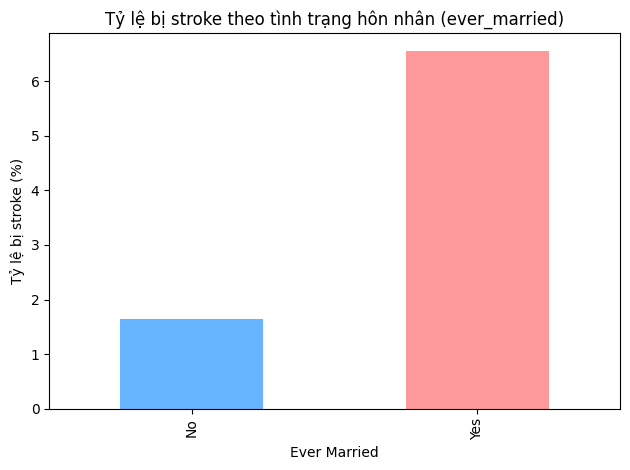

In [160]:
# Tính tỷ lệ stroke cho từng nhóm ever_married
stroke_rate = df.groupby('ever_married')['stroke'].mean() * 100

# Vẽ biểu đồ
stroke_rate.plot(kind='bar', color=['#66b3ff', '#ff9999'])
plt.ylabel('Tỷ lệ bị stroke (%)')
plt.title('Tỷ lệ bị stroke theo tình trạng hôn nhân (ever_married)')
plt.xlabel('Ever Married')
plt.tight_layout()
plt.show()

--> Có vẻ ... hơi mắc cười nhỉ =))) Đã từng kết hôn có tỷ lệ đột quỵ cao hơn là chưa từng kết hôn cơ à =)) (gấp 3 luôn ấy ảo thật)

In [161]:
from scipy.stats import chi2_contingency

# Tạo bảng chéo
contingency = pd.crosstab(df['ever_married'], df['stroke'])

# Kiểm định Chi-squared
chi2, p, dof, expected = chi2_contingency(contingency)
print(f"Chi2 statistic: {chi2:.2f}, p-value: {p:.4f}")

if p < 0.05:
    print("Có mối liên hệ có ý nghĩa thống kê giữa ever_married và stroke.")
else:
    print("Không có mối liên hệ có ý nghĩa thống kê giữa ever_married và stroke.")

Chi2 statistic: 58.92, p-value: 0.0000
Có mối liên hệ có ý nghĩa thống kê giữa ever_married và stroke.


-->  Ý nghĩa chính của kiểm định Chi2 là để kiểm tra xem có mối liên hệ (association) hoặc sự phụ thuộc (dependence) có ý nghĩa thống kê giữa hai hoặc nhiều biến phân loại hay không. Với p < 1-x (x là độ tin cậy cho trước, thường là 95% nha) thì có coi là có mối liên hệ có ý nghĩa thống kê giữa hai biến.


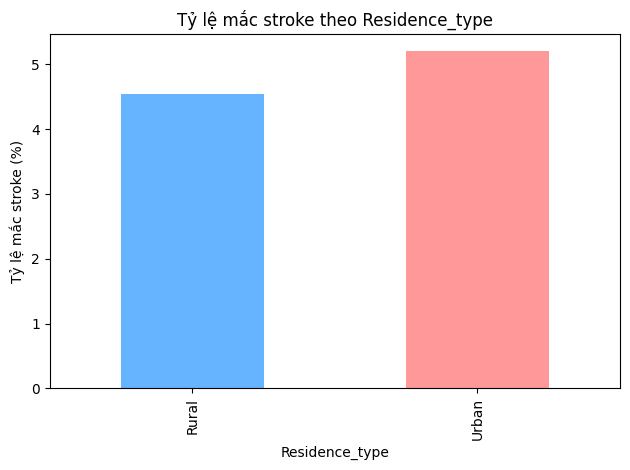

In [162]:
# Tính tỷ lệ phần trăm mắc stroke theo từng nhóm Residence_type
stroke_rate = df.groupby('Residence_type')['stroke'].mean() * 100

stroke_rate.plot(kind='bar', color=['#66b3ff', '#ff9999'])
plt.ylabel('Tỷ lệ mắc stroke (%)')
plt.title('Tỷ lệ mắc stroke theo Residence_type')
plt.xlabel('Residence_type')
plt.tight_layout()
plt.show()

--> Urban cao hơn Rural, tuy nhiên chênh lệch là không đáng kể. Mặt khác, tôi thấy một vài người nói rằng sống ở thành thị thường căng thẳng, liên quan đến bệnh huyết áp cao, mà huyết áp cao cũng liên quan đến việc stroke hay không (như ta phân tích ban nãy). Chúng ta cùng kiểm tra xem nha !

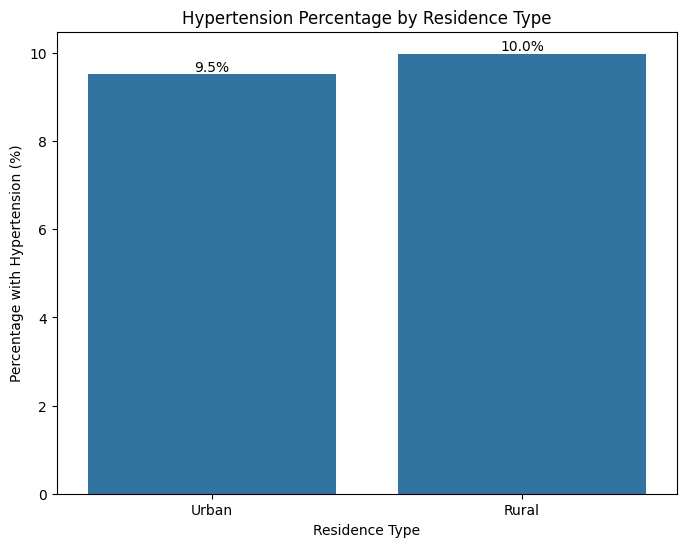

In [163]:
# Create a percentage plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df, x='Residence_type', y='hypertension', 
                 estimator=lambda x: sum(x)*100/len(x), errorbar=None)
plt.title('Hypertension Percentage by Residence Type')
plt.xlabel('Residence Type')
plt.ylabel('Percentage with Hypertension (%)')

# Add percentage labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

plt.show()

--> Như chúng ta thấy dưới đây, có vẻ nhiều người nói ra có thể cũng không đúng lắm. Đối với tập dữ liệu này thì rural bị hypertension lại cao hơn nhiều urban :D Mặc dù chênh lệch là thấp :D Chứng tỏ rằng thực tế việc sống ở đâu không liên quan đến bị hypertension hay không. Đôi khi việc sống ở các thành phố lớn như HN, HCM, ... chúng ta áp lực thật: chi phí sinh hoạt, môi trường sống, ... thế nhưng thực tế việc ở rural cũng không vui vẻ như chúng ta thấy trên phim. Họ (hay gia đình tôi nói riêng) cũng có những vấn đề tương tự như cơm áo gạo tiền, áp lực vượt khó, những định kiến "cổ hủ" đeo bám, ... Vậy nên, hãy trân trọng nơi bạn sống, hãy cảm thấy yêu mến nơi bạn ở. Đó mới là tinh thần sống đích thực

--> Tóm lại, biến này không liên quan đến stroke hay không vì chưa có bằng chứng nào cụ thể cả ở về mặt nghiên cứu KH

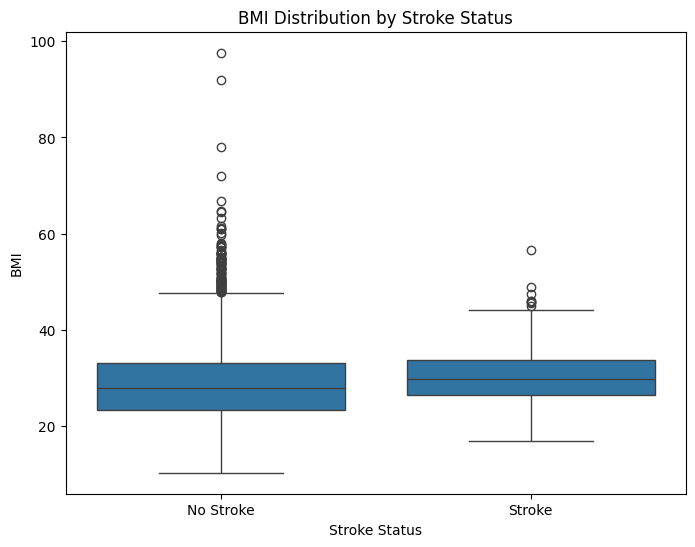

In [164]:
# 3. Visualization - Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='stroke', y='bmi')
plt.xticks([0, 1], ['No Stroke', 'Stroke'])
plt.title('BMI Distribution by Stroke Status')
plt.xlabel('Stroke Status')
plt.ylabel('BMI')
plt.show()

--> Đối với biến BMI, như chúng ta thấy rằng: sự chênh lệch giữa 2 đồ thị (chiều dài boxplot tính theo chiều dài chiếu lên trục Oy) không có sự chênh lệch (ý là 2 boxplot này đứng gần như ngang nhau). Mặt khác, trung vị của chúng cũng gần như ngang nhau. Chứng tỏ rằng hầu như không có sự chênh lệch gì trong chỉ số BMI của người bị stroke hay không stroke. Hay nói đơn giản hơn, biến BMI không liên quan đến việc stroke hay không

--> Tuy nhiên, theo trung tâm y tế quận gò vấp - TPHCM (https://trungtamytegovap.medinet.gov.vn/ban-tin-truyen-thong/nguoi-beo-phi-co-nguy-co-mac-cac-benh-gi-cmobile14393-112777.aspx) thì có đề cập đến rằng việc người có chỉ số BMI từ 30 (thừa cân cấp độ II) trở lên được xem là béo phì và có nguy cơ mắc các bệnh tim mạch và đột quỵ cao hơn nhiều so với người có BMI bình thường (người bình thường: 18,5 – 22,9). Chúng ta cùng kiểm chứng ở tập dữ liệu này xem sao

In [165]:
# Percentage of stroke more than 30 on total people more than 30
more_than_30_bmi_stroke = df[(df['bmi'] >= 30) & (df["stroke"] == 1)]
more_than_30_bmi = df[df['bmi'] >= 30]
print(len(more_than_30_bmi_stroke)*100/len(more_than_30_bmi))

5.104166666666667


--> Ta thấy rằng tỷ lệ đó chỉ là 5.1%. Rất thấp, trong khi đó ta xem xét tỷ lệ những người bị stroke < 30 trên tổng số người < 30

In [166]:
# Percentage of stroke less than 30 on total people less than 30
less_than_30_bmi_stroke = df[(df['bmi'] < 30) & (df["stroke"] == 1)]
less_than_30_bmi = df[df['bmi'] < 30]
print(len(less_than_30_bmi_stroke)*100/len(less_than_30_bmi))

3.713616594178655


--> Chiếm khoảng 3,7%, gần ngang bằng. Chênh lệch so với 5% không đáng bao nhiêu, chứng tỏ thực tế rằng chưa có căn cứ kết luận rằng chỉ số BMI thực sự liên quan đến bệnh stroke.

Tuy nhiên rằng, tôi vẫn khuyên các bạn nên quan tâm đến sức khỏe và cân nặng của mình. Mặc dù BMI không phải là yếu tố quyết định, thế nhưng việc thừa cân béo phì có thể gây ra vài vấn đề tới sức khỏe của chúng ta:
1. Rối loạn chuyển hóa và nội tiết
+ Hội chứng chuyển hóa: mỡ thừa làm giảm độ nhạy insulin, dẫn đến kháng insulin và tăng nguy cơ đái tháo đường type 2.
+ Rối loạn lipid máu: tăng cholesterol xấu (LDL), triglyceride, giảm cholesterol tốt (HDL), gây xơ vữa động mạch, tăng nguy cơ nhồi máu cơ tim, đột quỵ.
+ Mất cân bằng hormone: nữ giới dễ rối loạn kinh nguyệt, hội chứng buồng trứng đa nang, vô sinh; nam giới giảm testosterone, suy giảm ham muốn và khả năng sinh sản.
2. Bệnh tim mạch
+ Béo phì làm tăng áp lực lên tim, gây tăng huyết áp, xơ vữa động mạch, nguy cơ nhồi máu cơ tim, đột quỵ cao hơn
3. Các vấn đề khác
+ Rối loạn sinh sản, vô sinh; các vấn đề về da như nhiễm trùng vùng hăm kẽ, rạn da; ảnh hưởng tâm lý, khó thở, tăng nguy cơ gãy xương ở trẻ béo phì  
--> Vậy nên, tốt hơn hết hãy duy trì cân nặng hợp lý, chịu khó thể dục thể thao và ăn uống lành mạnh để tránh những bệnh tật không đáng có

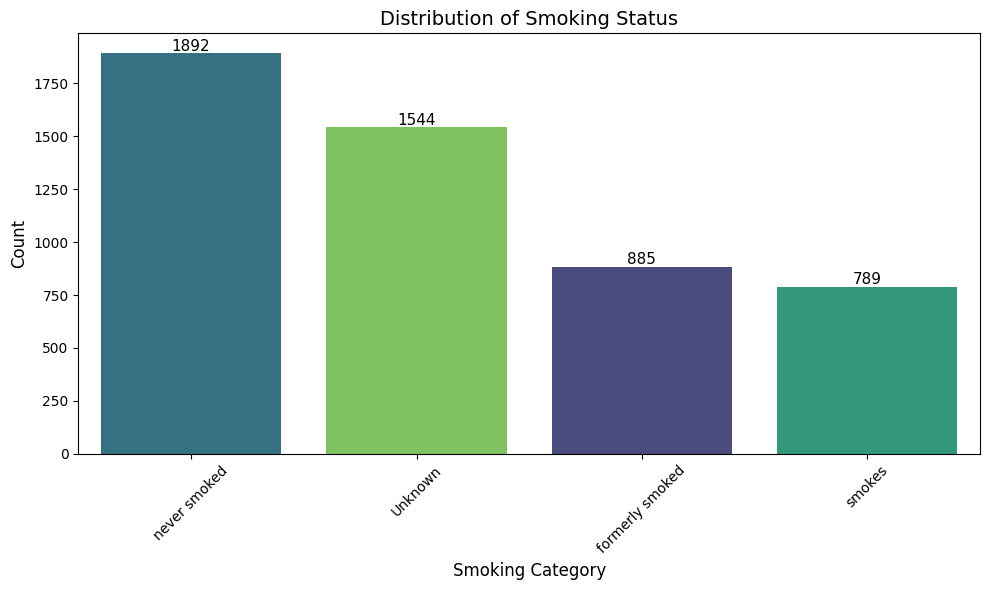

In [167]:
# Plot value counts with percentages
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=df, 
    x='smoking_status',
    hue="smoking_status", 
    order=df['smoking_status'].value_counts().index,
    palette='viridis'
)

# Add counts and percentages on bars
total = len(df)
for p in ax.patches:
    percentage = 100 * p.get_height()/total
    ax.annotate(
        f'{int(p.get_height())}', 
        (p.get_x() + p.get_width()/2., p.get_height()),
        ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
        textcoords='offset points'
    )

plt.title('Distribution of Smoking Status', fontsize=14)
plt.xlabel('Smoking Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

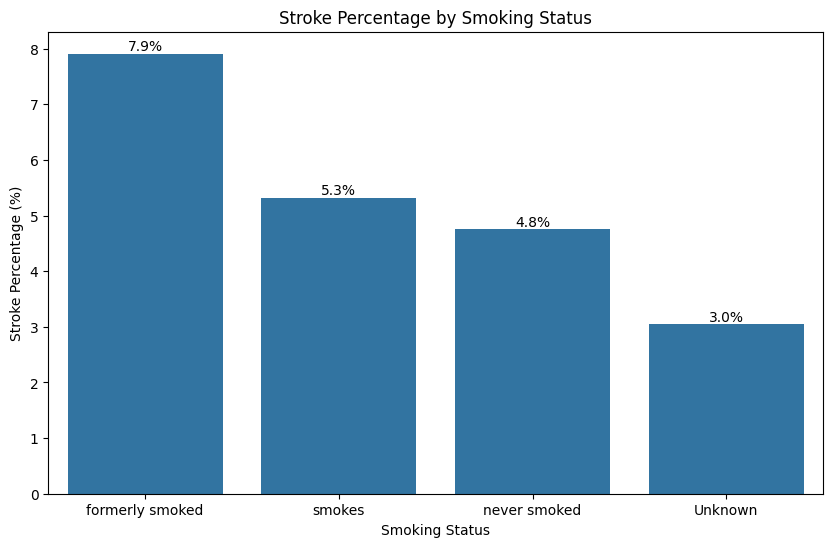

In [168]:
# Calculate stroke percentages by smoking status
stroke_percent = df.groupby('smoking_status')['stroke'].mean() * 100
stroke_percent = stroke_percent.sort_values(ascending=False)

# Create ordered list of categories
order = stroke_percent.index.tolist()

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df, x='smoking_status', y='stroke', 
                 order=order,
                 estimator=lambda x: sum(x)*100/len(x), 
                 errorbar=None)
plt.title('Stroke Percentage by Smoking Status')
plt.xlabel('Smoking Status')
plt.ylabel('Stroke Percentage (%)')

# Add percentage labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

plt.show()

--> Mặc dù là số lượng người hút thuốc lá (tính cả hút và đã hút) được khảo sát chiếm ít hơn never smoked. Song, tỷ lệ mắc lại hơn là số người chưa từng hút và Unknown

--> Có xu hướng tăng tính từ người không smokes dần đến người đã từng smoke. Nếu ta gộp những người đã hút thuốc vào làm 1 thì tỷ lệ phần trăm người bị đột quỵ do dính đáng dến việc hút thuốc (7.9% + 5.3%) gấp gần 3 lần tỷ lệ phần trăm người chưa từng hút thuốc (4.8%). Chứng tỏ hút thuốc cũng là 1 trong những tác nhân chính dẫn đến việc đột quỵ.

Mặc dù biết việc hút thuốc lá là nguy hiểm. Song, nhiều người lại không thể cai được. Tiện đây, tôi sẽ chỉ cho bạn 1 vài cách cai thuốc lá mà tôi tham khảo được như sau:

### 1. Lên kế hoạch và cắt giảm dần
*   **Xác định quyết tâm:** Đặt mục tiêu rõ ràng và lên kế hoạch cai thuốc cụ thể.
*   **Giảm dần số lượng:** Cắt giảm từ từ số lượng thuốc lá hút mỗi ngày để cơ thể thích nghi và tránh các triệu chứng khó chịu khi dừng đột ngột.

### 2. Tập thể dục và hoạt động thể chất
*   **Hoạt động nhẹ nhàng:** Thực hiện các bài tập như đi bộ, yoga, khiêu vũ.
*   **Lợi ích:** Giúp giảm cơn thèm nicotine, cải thiện tâm trạng và hỗ trợ kiểm soát cân nặng trong quá trình cai thuốc.

### 3. Quản lý căng thẳng
*   **Kỹ thuật thư giãn:** Áp dụng các phương pháp như thở sâu, thiền định, nghe nhạc nhẹ nhàng, hoặc mát-xa.
*   **Mục đích:** Kiểm soát căng thẳng, một trong những yếu tố thường kích hoạt cơn thèm thuốc.

### 4. Chế độ ăn uống lành mạnh
*   **Tăng cường rau quả:** Ăn nhiều trái cây (đặc biệt là cam, quýt) và rau xanh.
*   **Uống nhiều nước:** Giúp thanh lọc cơ thể, giảm cảm giác thèm thuốc và cải thiện sức khỏe tổng thể.

### 5. Sử dụng các liệu pháp thay thế nicotine (NRT - Nicotine Replacement Therapy)
*   **Sản phẩm hỗ trợ:** Kẹo cao su nicotine, viên ngậm nicotine có thể giúp kiểm soát cơn thèm và giảm các triệu chứng cai nghiện.
*   **Lưu ý:** Nên tham khảo ý kiến bác sĩ hoặc dược sĩ trước khi sử dụng.

### 6. Các phương pháp dân gian và thảo dược
*   **Thành phần tự nhiên:** Sử dụng yến mạch, ớt cayenne, gừng, cây lobelia, nước ép củ cải, nhân sâm, valerian (nữ lang).
*   **Công dụng:** Hỗ trợ giảm các triệu chứng như buồn nôn, lo âu, và căng thẳng liên quan đến việc cai thuốc.

### 7. Thay đổi thói quen và môi trường
*   **Vệ sinh răng miệng:** Đánh răng thường xuyên, sử dụng nước súc miệng bạc hà hoặc trà xanh khi thèm thuốc.
*   **Tránh xa cám dỗ:** Hạn chế tiếp xúc với người hút thuốc và môi trường có khói thuốc. Kết bạn và dành thời gian với những người không hút thuốc.

### 8. Tránh các chất kích thích
*   **Hạn chế đồ uống:** Giảm tiêu thụ rượu bia, nước ngọt có ga vì chúng có thể làm tăng cảm giác thèm thuốc lá.

### 9. Tìm kiếm sự hỗ trợ
*   **Tư vấn chuyên nghiệp:** Tham gia các chương trình tư vấn cai thuốc lá.
*   **Hỗ trợ cộng đồng:** Tham gia các nhóm hỗ trợ cai thuốc.
*   **Hỗ trợ y tế:** Sử dụng thuốc hỗ trợ cai thuốc lá theo chỉ định và hướng dẫn của bác sĩ để tăng cơ hội thành công.

In [169]:
# 1. Create contingency table
contingency_table = pd.crosstab(df['work_type'], df['stroke'])
print("Contingency Table:")
print(contingency_table)
print("\n")

Contingency Table:
stroke            0    1
work_type               
Govt_job        624   33
Never_worked     22    0
Private        2776  149
Self-employed   754   65
children        685    2




In [170]:
# 2. Calculate percentages
print("Stroke Percentage by Work Type:")
percentage_table = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100
print(percentage_table)
print("\n")

Stroke Percentage by Work Type:
stroke                  0         1
work_type                          
Govt_job        94.977169  5.022831
Never_worked   100.000000  0.000000
Private         94.905983  5.094017
Self-employed   92.063492  7.936508
children        99.708879  0.291121




--> Ta thấy bên cột 0 lớn hơn nhiều 1 là chuyện hiển nhiên vì dữ liệu có sự chênh lệch lớn giữa 0 và 1

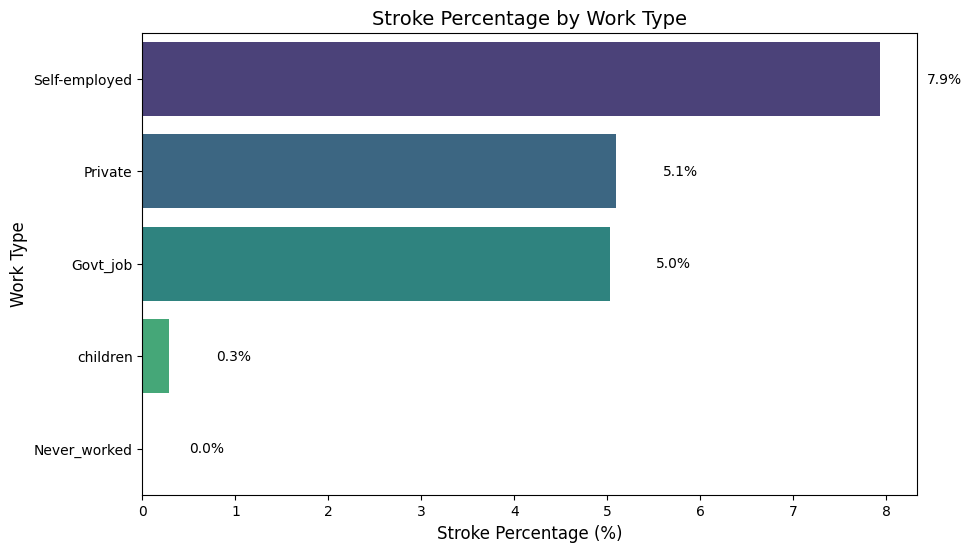

In [171]:
# 3. Visualization - Sorted Percentage Plot

# Sort the DataFrame by the percentage column (column with index 1)
stroke_percentage_by_work_type = percentage_table.sort_values(by=1, ascending=False)

plt.figure(figsize=(10, 6))

# Create a horizontal bar plot for better readability of work types
ax = sns.barplot(x=stroke_percentage_by_work_type[1],
                 y=stroke_percentage_by_work_type.index,
                 hue=stroke_percentage_by_work_type.index,
                 palette="viridis")

plt.title('Stroke Percentage by Work Type', fontsize=14)
plt.xlabel('Stroke Percentage (%)', fontsize=12)
plt.ylabel('Work Type', fontsize=12)

# Add percentage labels to horizontal bars
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.5,
             p.get_y() + p.get_height()/2,
             f'{width:.1f}%',
             ha='left',
             va='center')

plt.show()

--> Ta thấy mặc dù là self-employed có tỷ lệ cao nhất là 7.9%. Song các giá trị còn lại như private, govt_job cũng gần ngang ngửa. Kết quả tra cứu từ các nguồn đáng tin cậy (như tạp chí The Lancet) chỉ ra rằng làm việc quá nhiều giờ (trên 55 giờ mỗi tuần) và công việc áp lực cao có thể làm tăng đáng kể nguy cơ đột quỵ, tuy nhiên việc làm việc ở môi trường nào thì theo tôi cũng đều áp lực như nhau

Tóm lại, trong khi bản thân tên gọi của loại hình công việc có thể không phải là nguyên nhân trực tiếp, các điều kiện và yếu tố liên quan đến công việc (như thời gian làm việc, mức độ căng thẳng, lối sống) có khả năng ảnh hưởng đến nguy cơ đột quỵ của một người

--> Kết luận: cột này không ảnh hưởng đến target

## Clean data and do some feature engineering

1. Change all categorical column to number

In [172]:
# Lấy ra tất cả các cột có kiểu dữ liệu là string
str_col = df.select_dtypes(include=['object']).columns
print(str_col)

Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')


In [173]:
# Xử lý cột gender
print(f"Giá trị duy nhất của cột gender: {df["gender"].unique()}")

# Mã hóa OHE (One-hot-encoding) vì như ta phân tích giới tính là nam/nữ không ảnh hưởng đến stroke.
# Tức nam/nữ có vai trò như nhau
df = pd.get_dummies(df, columns=['gender'], dtype=int, prefix='', prefix_sep='')

Giá trị duy nhất của cột gender: ['Male' 'Female' 'Other']


In [174]:
# Xử lý cột work_type
print(f"Giá trị duy nhất của cột work_type: {df["work_type"].unique()}")

# Mã hóa OHE (One-hot-encoding) vì như ta phân tích giới tính là work_type không ảnh hưởng đến stroke.
# Tức worktype nào thì vai trò cũng là như nhau
df = pd.get_dummies(df, columns=['work_type'], dtype=int, prefix='', prefix_sep='')

Giá trị duy nhất của cột work_type: ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']


In [175]:
print(df['ever_married'].value_counts())
# Convert 'ever_married' column from Yes/No to 1/0
df['ever_married'] = df['ever_married'].map({'Yes': 1, 'No': 0}).astype('int8')

ever_married
Yes    3353
No     1757
Name: count, dtype: int64


In [176]:
print(df['Residence_type'].value_counts())
# Residence_type OHE because values are nominal
df = pd.get_dummies(df, columns=['Residence_type'], dtype=int, prefix='', prefix_sep='')

Residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64


In [177]:
print(df['smoking_status'].value_counts())

# Because of the sophisticated of this column, i will encode followed by the rules: anyone who smokes
# is encoded as 1, anyone who never smoked is encoded as 0, and anyone who unknown is encoded as -1
df['smoking_status'] = df['smoking_status'].map({
    'formerly smoked': 1,
    'smokes': 1, 
    'never smoked': 0,
    'Unknown': -1
})

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64


In [178]:
df.head()

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,smoking_status,stroke,Female,Male,Other,Govt_job,Never_worked,Private,Self-employed,children,Rural,Urban
0,67.0,0,1,1,228.69,36.6,1,1,0,1,0,0,0,1,0,0,0,1
1,61.0,0,0,1,202.21,NaN,0,1,1,0,0,0,0,0,1,0,1,0
2,80.0,0,1,1,105.92,32.5,0,1,0,1,0,0,0,1,0,0,1,0
3,49.0,0,0,1,171.23,34.4,1,1,1,0,0,0,0,1,0,0,0,1
4,79.0,1,0,1,174.12,24.0,0,1,1,0,0,0,0,0,1,0,1,0


2. Tìm các giá trị có vẻ không hợp lệ trong các cột số

In [179]:
# Xem qua có tuổi nào bị âm hay quá lớn không
print(df["age"].value_counts())

age
78.00    102
57.00     95
52.00     90
54.00     87
51.00     86
        ... 
1.40       3
0.48       3
0.16       3
0.08       2
0.40       2
Name: count, Length: 104, dtype: int64


In [180]:
# Xem có chí số BMI nào âm không
print(df['bmi'].value_counts().sort_index())

bmi
10.3    1
11.3    1
11.5    1
12.0    1
12.3    1
       ..
66.8    1
71.9    1
78.0    1
92.0    1
97.6    1
Name: count, Length: 418, dtype: int64


In [181]:
# Xem có chí số glucose nào âm không
print(df['avg_glucose_level'].value_counts().sort_index())

avg_glucose_level
55.12     1
55.22     1
55.23     1
55.25     1
55.26     1
         ..
266.59    1
267.60    1
267.61    1
267.76    1
271.74    1
Name: count, Length: 3979, dtype: int64


3. Loại bỏ trùng

In [182]:
df.drop_duplicates(inplace=True)

4. Xử lý NULL

Chia tập dữ liệu trước

In [183]:
X = df.drop('stroke', axis=1)
y = df['stroke']

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Xử lý null cột BMI

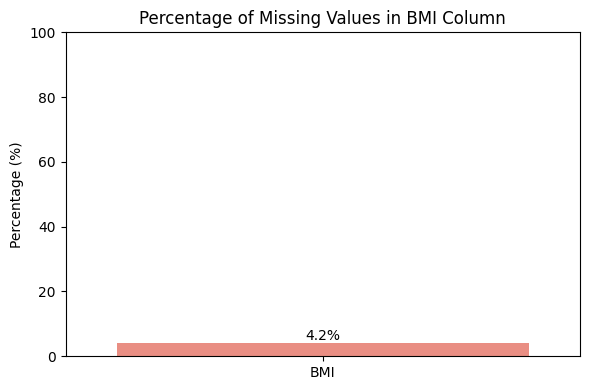

In [185]:
# Calculate null percentage
null_percentage = (X_train['bmi'].isnull().mean()) * 100

# Create bar plot
plt.figure(figsize=(6, 4))
sns.barplot(x=['BMI'], y=[null_percentage], color='salmon')
plt.title('Percentage of Missing Values in BMI Column')
plt.ylabel('Percentage (%)')
plt.ylim(0, 100)

# Add value label on top of bar
for i, v in enumerate([null_percentage]):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')

plt.tight_layout()
plt.show()

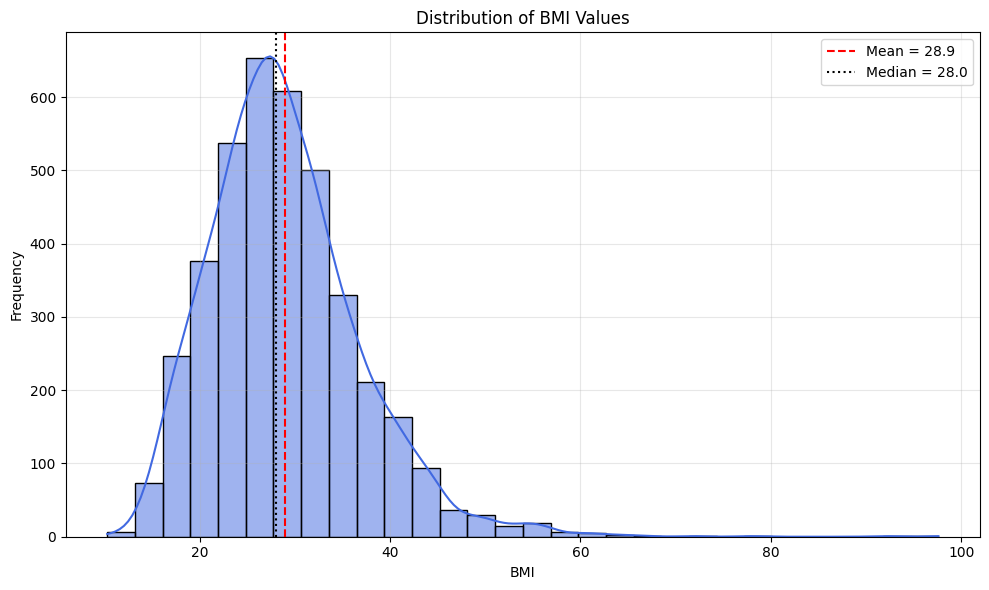

In [186]:
plt.figure(figsize=(10, 6))

# Histogram with KDE
sns.histplot(X_train['bmi'], kde=True, color='royalblue', bins=30)

# Add title and labels
plt.title('Distribution of BMI Values')
plt.xlabel('BMI')
plt.ylabel('Frequency')

# Calculate statistics
mean_bmi = X_train['bmi'].mean()
median_bmi = X_train['bmi'].median()

# Add vertical lines
plt.axvline(mean_bmi, color='red', linestyle='--', 
           label=f'Mean = {mean_bmi:.1f}')
plt.axvline(median_bmi, color='black', linestyle=':', 
           label=f'Median = {median_bmi:.1f}')

# Add legend and grid
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

-> Thay thế giá trị thiếu bằng giá trị trung vị (vì có khá nhiều giá trị ngoại lệ)

In [187]:
# Tính toán median từ TRAIN SET và áp dụng cho cả train lẫn test
train_median = X_train['bmi'].median()
X_train['bmi'] = X_train['bmi'].fillna(train_median)
X_test['bmi'] = X_test['bmi'].fillna(train_median)

Xử lý ngoại lệ: tập trung vào 2 cột bmi và avg_glucose_level

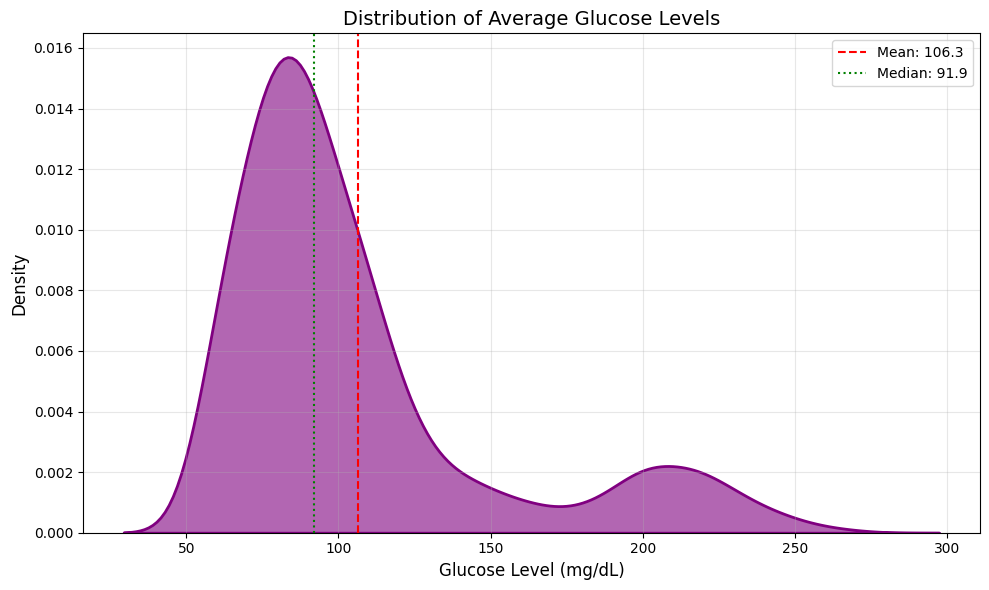

In [188]:
plt.figure(figsize=(10, 6))

# Create KDE plot with improved styling
sns.kdeplot(data=X_train, x='avg_glucose_level', 
           fill=True, color='purple', alpha=0.6,
           linewidth=2)

# Add statistical markers
mean_glucose = X_train['avg_glucose_level'].mean()
median_glucose = X_train['avg_glucose_level'].median()
plt.axvline(mean_glucose, color='red', linestyle='--', label=f'Mean: {mean_glucose:.1f}')
plt.axvline(median_glucose, color='green', linestyle=':', label=f'Median: {median_glucose:.1f}')

# Add title and labels
plt.title('Distribution of Average Glucose Levels', fontsize=14)
plt.xlabel('Glucose Level (mg/dL)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

-> Có vẻ phân phối của glucose khá ổn định, tồn tại 2 đỉnh tại khoảng 70 và 220. Phân phối trông có vẻ không bị lệch.

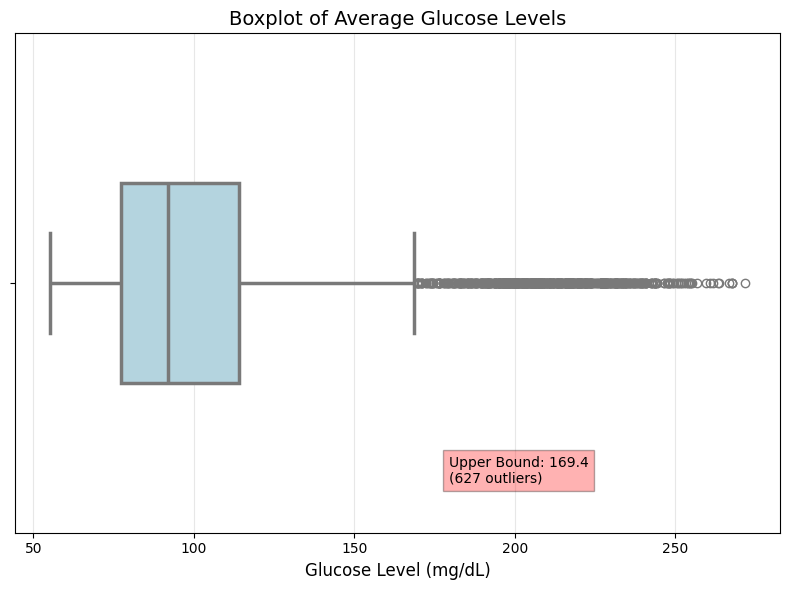

In [189]:
plt.figure(figsize=(8, 6))

# Create boxplot with enhanced styling
box = sns.boxplot(x=df['avg_glucose_level'], 
                 color='lightblue', 
                 width=0.4,
                 linewidth=2.5)

# Calculate and mark outliers
Q1 = df['avg_glucose_level'].quantile(0.25)
Q3 = df['avg_glucose_level'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5*IQR

# Add annotations
plt.title('Boxplot of Average Glucose Levels', fontsize=14)
plt.xlabel('Glucose Level (mg/dL)', fontsize=12)
plt.text(x=upper_bound+10, y=0.4, 
        s=f'Upper Bound: {upper_bound:.1f}\n({len(df[df["avg_glucose_level"] > upper_bound])} outliers)',
        bbox=dict(facecolor='red', alpha=0.3))

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

--> Như ta thấy, ở boxplot chỉ ra rằng có 627 outliers (khoảng giá trị không phải ngoại lệ chỉ khoảng từ 60 đến 170). Tuy nhiên như ta có vẽ ở trước đó thì tại giá trị gần 220 ta thấy có rất nhiều giá trị tập trung tại đó nên ta sẽ giữ lại các giá trị này. Tức với TH này thì cột này chúng ta sẽ KHÔNG XỬ LÝ NGOẠI LỆ

In [190]:
# Calculate IQR and bounds for column bmi
Q1 = X_train['bmi'].quantile(0.25)
Q3 = X_train['bmi'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = X_train[(X_train['bmi'] < lower_bound) | (X_train['bmi'] > upper_bound)]
outlier_percent = (len(outliers) / len(X_train)) * 100

print(f"Outlier Analysis for BMI:")
print(f"- Lower bound: {lower_bound:.2f}")
print(f"- Upper bound: {upper_bound:.2f}")
print(f"- Number of outliers: {len(outliers)}")
print(f"- Percentage of outliers: {outlier_percent:.2f}%")

Outlier Analysis for BMI:
- Lower bound: 10.30
- Upper bound: 46.30
- Number of outliers: 101
- Percentage of outliers: 2.47%


--> Mặc dù ở trên ta đã đưa ra bằng chứng về việc chỉ số BMI không thực sự liên quan đến việc 1 người bị stroke hay không. Tuy vậy, việc loại bỏ các outliers này ta cũng nên xem xét kỹ vì:
1. Nó có thể làm giảm số lượng stroke trong khi số lượng người bị mắc stroke của chúng ta đang ít
2. Mất đi một vài thông tin quan trọng giúp mô hình dự đoán các TH ngoại lệ

In [191]:
# Lấy ra bảng chỉ có outlier BMI
outlier_bmi_X_train = X_train[(X_train['bmi'] < lower_bound) | (X_train['bmi'] > upper_bound)]["bmi"]

# Lấy ra các giá trị y tương ứng
y_train_outlier_bmi = y_train[outlier_bmi_X_train.index]

In [192]:
print(f"Số lượng người bị stroke trong outlier BMI: {sum(y_train_outlier_bmi)}")
print(f"Số lượng người không bị stroke trong outlier BMI: {len(y_train_outlier_bmi)-sum(y_train_outlier_bmi)}")
print(f"Tỷ lệ phân trăm mắc bệnh của người BMI outlier trong số các người được khảo sát: {y_train_outlier_bmi.sum() * 100/ len(outlier_bmi_X_train):.2f}%")
print(f"Tỷ lệ phần trăm người mắc bệnh BMI trên toàn bộ tập dữ liệu: {sum(y)*100/len(y):.2f}%")

Số lượng người bị stroke trong outlier BMI: 3
Số lượng người không bị stroke trong outlier BMI: 98
Tỷ lệ phân trăm mắc bệnh của người BMI outlier trong số các người được khảo sát: 2.97%
Tỷ lệ phần trăm người mắc bệnh BMI trên toàn bộ tập dữ liệu: 4.87%


-> Số lượng mẫu bị stroke nếu ta loại bỏ outliers cho cột BMI là 3, một con số rất ít. Mặt khác đa phần người bị BMI lại không bị stroke. Như ta phân tích ở phần EDA thì yếu tố ảnh hưởng lớn đến một người bị stroke hay không chủ yếu là do: age cao, huyết áo cao. Ta cùng xem các trường hợp bị stroke ở đây có thuộc vào nhóm đó không

In [193]:
# Chỉ lấy ra những chỉ số người bị stroke
indices = y_train_outlier_bmi[y_train_outlier_bmi == 1].index.tolist()

# Xem thông tin ở các cột age và hypertension tương ứng
X_train.loc[indices,["age","hypertension"]]

,age,hypertension
113,45.0,0
21,52.0,1
66,70.0,0


--> Ta thấy tuổi đúng là tương đối cao (trên 40 như ta nhận định lúc EDA), trong 3 người thì có 1 người bị hypertension. Kết luận rằng các stroke này rơi vào các TH dễ bị stroke (không phải "hàng hiếm"). Vậy nên ta loại bỏ được 3 outliers này.

In [194]:
# Lọc bỏ outliers
X_train = X_train[(X_train['bmi'] >= lower_bound) & (X_train['bmi'] <= upper_bound)]
y_train = y_train[X_train.index]

5. Chuẩn hóa dữ liệu

Do tồn tại nhiều cột chỉ mang 0,1 nên tôi sẽ dùng min max scaler

In [195]:
# 1. Lưu tên cột
feature_names = X_train.columns

# 2. Khởi tạo và áp dụng MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Chuyển đổi về DataFrame
X_train = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test = pd.DataFrame(X_test_scaled, columns=feature_names)

## Huấn luyện mô hình trước khi sử dụng SMOTE

1. Định nghĩa không gian tham số (Parameter Distributions)

In [ ]:
param_distributions = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'], # Các loại penalty có thể
    'C': loguniform(1e-3, 1e2), # Phân phối log-uniform cho C (phổ biến) từ 0.001 đến 100
    'solver': ['liblinear', 'saga'], # Chọn solver hỗ trợ nhiều loại penalty
                                     # 'liblinear' cho l1/l2, 'saga' cho l1/l2/elasticnet/none
    'l1_ratio': uniform(0, 1) # Phân phối uniform cho l1_ratio (chỉ dùng khi penalty='elasticnet')
                               # từ 0 đến 1
}

2. Định nghĩa mô hình

In [197]:
log_reg = LogisticRegression(random_state=42, max_iter=1000, class_weight=None)

3. Thiết lập Stratified K-Fold Cross-Validation

In [198]:
cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

4. Khởi tạo RandomizedSearchCV

In [199]:
random_search = RandomizedSearchCV(
    estimator=log_reg,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='roc_auc',
    cv=cv_stratified,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

5. Bắt đầu huấn luyện

In [200]:
print("Bắt đầu Randomized Search để tìm tham số tốt nhất cho baseline...")
random_search.fit(X_train, y_train)
print("Randomized Search hoàn tất.")

Bắt đầu Randomized Search để tìm tham số tốt nhất cho baseline...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Randomized Search hoàn tất.


6. Xem các siêu tham số tốt nhất cho mô hình

In [201]:
print(f"\nTham số tốt nhất tìm được: {random_search.best_params_}")
print(f"Điểm {random_search.scoring} tốt nhất trên tập huấn luyện (cross-validation): {random_search.best_score_:.4f}")


Tham số tốt nhất tìm được: {'C': np.float64(0.15876781526924), 'l1_ratio': np.float64(0.12203823484477883), 'penalty': 'l1', 'solver': 'saga'}
Điểm roc_auc tốt nhất trên tập huấn luyện (cross-validation): 0.8372


7. Lấy ra mô hình tốt nhất tìm được

In [ ]:

best_baseline_model_random = random_search.best_estimator_

8. Đánh giá mô hình trên tập test

In [ ]:

print("\n--- Đánh giá mô hình Baseline TỐT NHẤT (từ RandomizedSearch) trên tập Test ---")
y_pred_best_baseline_random = best_baseline_model_random.predict(X_test)
y_pred_proba_best_baseline_random = best_baseline_model_random.predict_proba(X_test)[:, 1]


--- Đánh giá mô hình Baseline TỐT NHẤT (từ RandomizedSearch) trên tập Test ---


In [204]:
print("\nClassification Report (Best Baseline - RandomizedSearch):")
print(classification_report(y_test, y_pred_best_baseline_random, target_names=['No Stroke (0)', 'Stroke (1)']))

print("\nConfusion Matrix (Best Baseline - RandomizedSearch):")
print(confusion_matrix(y_test, y_pred_best_baseline_random))


Classification Report (Best Baseline - RandomizedSearch):
               precision    recall  f1-score   support

No Stroke (0)       0.95      1.00      0.97       972
   Stroke (1)       0.00      0.00      0.00        50

     accuracy                           0.95      1022
    macro avg       0.48      0.50      0.49      1022
 weighted avg       0.90      0.95      0.93      1022


Confusion Matrix (Best Baseline - RandomizedSearch):
[[972   0]
 [ 50   0]]


--> NHẬN XÉT:
+ precision = 0.00: Precision cho lớp "Stroke (1)" là 0. Điều này có nghĩa là trong tất cả các trường hợp mà mô hình dự đoán là có đột quỵ, không có trường hợp nào thực sự bị đột quỵ. Thực tế, nhìn vào ma trận nhầm lẫn, mô hình không hề dự đoán bất kỳ trường hợp nào là "Stroke (1)".
+ recall = 0.00: Recall (hay Độ nhạy - Sensitivity) cho lớp "Stroke (1)" là 0. Đây là chỉ số quan trọng nhất cho thấy sự thất bại của mô hình. Nó có nghĩa là trong tất cả các trường hợp thực tế bị đột quỵ trong tập kiểm tra (có 50 trường hợp, theo cột support), mô hình không phát hiện được bất kỳ trường hợp nào. Nó đã bỏ lỡ toàn bộ các ca bệnh.
+ f1-score = 0.00: F1-score là trung bình điều hòa của precision và recall. Vì cả hai đều bằng 0, F1-score cũng bằng 0.

--> Mô hình baseline rất tệ

## Huấn luyện mô hình sau khi sử dụng SMOTE

1. Xử lý Imbalance dataset: bằng SMOTE

In [205]:
# random_state để đảm bảo kết quả lặp lại được
smote = SMOTE(random_state=42)

print(f"Số lượng mẫu ban đầu trong y_train: {Counter(y_train)}")

Số lượng mẫu ban đầu trong y_train: Counter({0: 3791, 1: 196})


In [206]:
# Áp dụng SMOTE chỉ trên tập huấn luyện
# fit_resample sẽ trả về X_train và y_train mới đã được cân bằng
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [207]:
print(f"Số lượng mẫu sau khi áp dụng SMOTE: {Counter(y_train_smote)}")
print(f"Kích thước X_train sau SMOTE: {X_train_smote.shape}")

Số lượng mẫu sau khi áp dụng SMOTE: Counter({0: 3791, 1: 3791})
Kích thước X_train sau SMOTE: (7582, 17)


In [208]:
print("Bắt đầu Randomized Search để tìm tham số tốt nhất cho baseline...")
random_search.fit(X_train_smote, y_train_smote)
print("Randomized Search hoàn tất.")

Bắt đầu Randomized Search để tìm tham số tốt nhất cho baseline...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Randomized Search hoàn tất.


In [210]:
print(f"\nTham số tốt nhất cho mô hình trong pipeline: {random_search.best_params_}")
print(f"Điểm {random_search.scoring} tốt nhất (cross-validation): {random_search.best_score_:.4f}")


Tham số tốt nhất cho mô hình trong pipeline: {'C': np.float64(0.4108318894699929), 'l1_ratio': np.float64(0.42754101835854963), 'penalty': 'l2', 'solver': 'saga'}
Điểm roc_auc tốt nhất (cross-validation): 0.8492


In [212]:
best_model_random = random_search.best_estimator_

In [213]:
y_pred_best_random = best_model_random.predict(X_test)
y_pred_proba_best_random = best_model_random.predict_proba(X_test)[:, 1]

In [214]:
print("\nClassification Report (Best Baseline - RandomizedSearch):")
print(classification_report(y_test, y_pred_best_random, target_names=['No Stroke (0)', 'Stroke (1)']))

print("\nConfusion Matrix (Best Baseline - RandomizedSearch):")
print(confusion_matrix(y_test, y_pred_best_random))


Classification Report (Best Baseline - RandomizedSearch):
               precision    recall  f1-score   support

No Stroke (0)       0.99      0.74      0.85       972
   Stroke (1)       0.14      0.80      0.24        50

     accuracy                           0.75      1022
    macro avg       0.56      0.77      0.54      1022
 weighted avg       0.94      0.75      0.82      1022


Confusion Matrix (Best Baseline - RandomizedSearch):
[[723 249]
 [ 10  40]]


--> Cải thiện đáng kể. Tuy vậy ta để ý recall tại stroke(1) thì ta vẫn bỏ qua khoảng 20% người bệnh thực sự mắc bệnh. Đây vẫn là con số lớn. Tuy vậy, đây là project cho mô hình logistic regression nên tôi xin phép dừng lại. Các bạn có thể cải thiện mô hình bằng vài cách sau:  
1. Thử các Kỹ Thuật Sampling Khác:
Combined Sampling (SMOTEENN, SMOTETomek): Có thể giúp loại bỏ nhiễu và cải thiện Precision sau khi SMOTE.
Undersampling (có kiểm soát): Thử RandomUnderSampler với sampling_strategy không phải là 'majority' mà là một tỷ lệ cụ thể (ví dụ: 0.3, 0.5) để giữ lại nhiều thông tin lớp đa số hơn.
2. Thử class_weight='balanced' với Logistic Regression (đã tune): So sánh trực tiếp hiệu quả của phương pháp này với SMOTE.
3. Thử các Thuật Toán Khác: Các thuật toán dựa trên cây như Random Forest hoặc Gradient Boosting (XGBoost, LightGBM) thường xử lý dữ liệu mất cân bằng tốt hơn và có thể cho kết quả cân bằng hơn giữa Precision và Recall, đặc biệt khi kết hợp với class_weight hoặc các kỹ thuật sampling. Hãy thử tune các mô hình này.